# GET ALL DATAS  OF OBSTACLES AND DISTANCES 

In [45]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
#Imports needed
import numpy as np #For everything                              version 
import matplotlib.pyplot as plt #For visualisation              version 
import networkx as nx #For the graph                            version 
from pickle import load as pload #For loading the gpickle file  version 
from PIL import Image #For image management                     version 
from tqdm import tqdm #For nice loading bars                    version 
from declaration_tutti import load, treat_a_new_reseau, load_from_scratch
from fct_utils import prune,xy2t
from fct_analyse import arbre_genealogique_branches,color_by_time
#Our part:
from Reseau import Reseau,Brindille,Branche 
from scipy.optimize import curve_fit
from IPython.display import Image
from  functions_avoidment import vision_des_branches_alice
import math 

reseau= load('M2WT_200616',"branched")
for b in reseau.branches:
        b.n2x = reseau.n2x
        b.n2y = reseau.n2y
        b.n2t = reseau.n2t

# Find branch direction 

### What we did:
* We took the function of Thibault vision de branches that was giving for each time t a dictionary branch: TRUE/FALSE for OCCUPIED/ NOT
* We added in the function a function to get also the obstacle present, their distance etc.
* In the end we have a function that gives:
    * isFree dictionary of Y/N
    * closest_dictionary for each time we take only the closest obstacle wrt their reciprocal distance
    * We create a velocity and tangent function
    * RADIUS IS 62.5 angle is $\approx$ 52°



For each closest obstacle we calulate the distance from it and the direction vector $\hat{u}$ and its normal $\hat{n}$ in that moment so that: 
* $\hat{u} \cdot \hat{v} = v_{\\}$
  
* $\hat{u} \cdot \hat{n} = v_{p}$

##### Quindi ho ottenuto una struttura che ad ogni istante, per ogni ramo , mi dà il ramo più vicino e la sua distanza da questo. 
La struttura è del tipo: 

### {BRANCH INDEX : {'branch': CLOSEST BRANCH , 'distance' : CLOSEST DISTANCE} } 

##### $\rightarrow$ now we want to extract velocities and  angles among velocities vectors. 

### Situazione: 
abbiamo fatto la funzione che restituisce ( sperando che sia giusto) obstacles, obstacle_branches_ and closest_obstacles adesso devi: 
* per ogni closest obstacle calcola il vettore tangente alla curva e quello normale, così possiamo fare i prodotti scalari
* per ogni vettore ostacolato devi trovare la velocità in quella direzione
* devi trovare un modo per trovare gli avoidment in base a queste velocità e catalogare 

# FUNCTION TO CALCULATE TANGENT IN THE CLOSEST OBSTACLE POINT

* prendo il nodo di minima distanza e faccio un nodo avanti un nodo indietro sul branch e calcolo così il vettore direzione e la sua normale. Per rendere la normale dal lato dell'incoming branch sull'ostacolo dobbiamo accordarci che il segno delle x della normale e dell'ostacolo sia lo stesso , sennò lo cambiamo.
* le velocità le prendo dalla funzione positions_vitesses di thibault a cui ho sostituito : tolto la sottrazione di 0.5 così ho esattamente la velocità dell'apex in quell'istante di vicinanza all ' ostacolo


In [46]:
def tangent(node , branch): 
    nodi = branch.noeuds
    n2index = {n: i for i, n in enumerate(nodi)}
    index2n = {i: n for i, n in enumerate(nodi)}
    time_nodo = reseau.n2t[node]
    apex = node    
    try:
       pre_apex = branch.get_apex_at(time_nodo - 1)
    except ValueError:
        pre_apex = b.noeuds[0]
     
    direction = np.array([reseau.n2x[apex] - reseau.n2x[pre_apex],
                                  reseau.n2y[apex] - reseau.n2y[pre_apex]])
    norm =  np.linalg.norm(direction) 
    direction = direction / norm 
    theta = np.arctan2(direction[1], direction[0])
    direction_ort = np.array([direction[1], -direction[0]])
    return direction , direction_ort

def velocity ( branch, t):
    
    vel ,temps  = branch.positions_vitesses()[1] , branch.positions_vitesses()[2]
    t_index = np.where(temps == t)
    velocity = vel[t_index]
    
    return velocity 


# CALCULATE FOR EACH TIME t THE BRANCHES' OBSTACLES, THEIR DISTANCE, AND THE COMPONENTS OF SPEED WRT THE OBSTACLE. 

il dizionario lo facciamo :

{tempo t :  branch ostacolato , ostacolo, distanza , velocità rispetto all'ostacolo ($v_p , v_{\\}$)

In [47]:
dizionario={}
for  t in range(5, reseau.end +1 ,1):  #range from 1 to 55 
    dizionario[t] = {}
    isFree, obstacles , obstacles_branches ,closest_obstacles = vision_des_branches_alice(reseau, t = t , rayon = 62.5, demi_angle = 0.9 , show = False )
    
    for branch_index , values in closest_obstacles.items(): 
        dizionario[t][branch_index] = {}
        b = reseau.branches[branch_index]
        
        if b.ending == 'Fusion?': 
            fusion_node = b.noeuds[-1]
            obstacle = values['branch']
            nodi_obstacle = obstacle.noeuds
            if fusion_node in nodi_obstacle: # se finisci qui significa che b si fonderà sull'ostacolo 
                dizionario[t][branch_index]['fusione'] = 'si' 
        nodo = values['node'] 
        branch = values['branch'] 
        try : 
            tangente , normale  = tangent(nodo , branch) 
        except KeyError: continue
            
        velocità = velocity( b , t) 
        norm_vel = np.sqrt( (velocità[0][0])**2 + (velocità[0][1])**2 )
        v_parallel = np.dot( velocità , tangente ) #/ norm_vel
        '''
        if normale[0] * velocità[0][0] < 0: 
            u = velocità[0][0] 
            y = -u
            velocità[0][0] = y
            normale[0] = -normale[0] 
        '''
        v_perp = np.dot(velocità , normale)# /norm_vel
        dizionario[t][branch_index]['v_\\'] = float(v_parallel[0]) 
        dizionario[t][branch_index]['v_perp'] = float(v_perp[0])
        dizionario[t][branch_index]['obstacle'] = branch

controlla: 
* Perchè tutte quelle velocità sono zero?  
* ci sono dei nodi che risultano di un branch che in realtà non lo sono. 

Thibault dice: 

$\forall$ braches plotta un punto sul diagramma di fase per ogni "prima comparsa con ostacolo", ad esempio

In [48]:
dizionario_branches = {}
for t in dizionario.keys():
    for b , vel in dizionario[t].items(): 
     
        if b not in dizionario_branches.keys():
            dizionario_branches[b] = {} 
            dizionario_branches[b][t] = vel
        else: 
            dizionario_branches[b][t] = vel


# TAKING ONLY BRANCHES THAT HAVE THE SAME OBSTACLE FOR 2+ FRAMES 

In [49]:
cut_dictionary = {} 
for b , values in dizionario_branches.items():
    tempi = list(values.keys()) 
    if len(tempi) == 1: 
        continue
 
    for t in tempi: 
        i = tempi.index(t)
        #print(i , len(tempi) , tempi)
        if i + 1  == len(tempi): #per gli ultimi elementi 
            #print('ci sono')
            if  t - 1  == tempi[i - 1]:
                if  values[t]['obstacle'] == values[tempi[i-1]]['obstacle']:
                    vel = values[t]
                    
                    if b not in cut_dictionary.keys():
                        cut_dictionary[b] = {} 
                        cut_dictionary[b][t] = vel
                    else: 
                        cut_dictionary[b][t] = vel
        if i == 0:
            #print('qui')
            if t + 1  == tempi[i+1] :
                if values[t]['obstacle'] == values[tempi[i+1]]['obstacle']:
                    vel = values[t]
                    
                    if b not in cut_dictionary.keys():
                        cut_dictionary[b] = {} 
                        cut_dictionary[b][t] = vel
                    else: 
                        cut_dictionary[b][t] = vel
        if i + 1  != len(tempi) and i!=0 : 
            #print('poi qui') 
            if t + 1  == tempi[i+1] or  t - 1 == tempi[i - 1]:
                if values[t]['obstacle'] == values[tempi[i+1]]['obstacle'] or values[t]['obstacle'] == values[tempi[i-1]]['obstacle']:
                    vel = values[t]
                    
                    if b not in cut_dictionary.keys():
                        cut_dictionary[b] = {} 
                        cut_dictionary[b][t] = vel
                    else: 
                        cut_dictionary[b][t] = vel


In [50]:
cut_dictionary

{792: {7: {'v_\\': 46.77055790195635,
   'v_perp': -15.389797972880242,
   'obstacle': Branche 794 - 292 noeuds},
  8: {'v_\\': 1.3416407864998712,
   'v_perp': -0.44721359549995704,
   'obstacle': Branche 794 - 292 noeuds},
  9: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds},
  41: {'fusione': 'si',
   'v_\\': 51.41075683366809,
   'v_perp': -2.2483610763114967,
   'obstacle': Branche 1320 - 351 noeuds},
  42: {'fusione': 'si',
   'v_\\': 17.019580319358127,
   'v_perp': -19.705929092280595,
   'obstacle': Branche 1320 - 351 noeuds}},
 1: {8: {'fusione': 'si',
   'v_\\': 0.9558277479553211,
   'v_perp': 1.1560247904948489,
   'obstacle': Branche 788 - 773 noeuds},
  9: {'v_\\': 1.5144563320384594,
   'v_perp': -0.45433689961153784,
   'obstacle': Branche 768 - 154 noeuds},
  10: {'v_\\': 4.5931283632698126,
   'v_perp': -1.4208958246086472,
   'obstacle': Branche 768 - 154 noeuds},
  14: {'v_\\': 5.709072006525955,
   'v_perp': -1

# t = 2 figures  

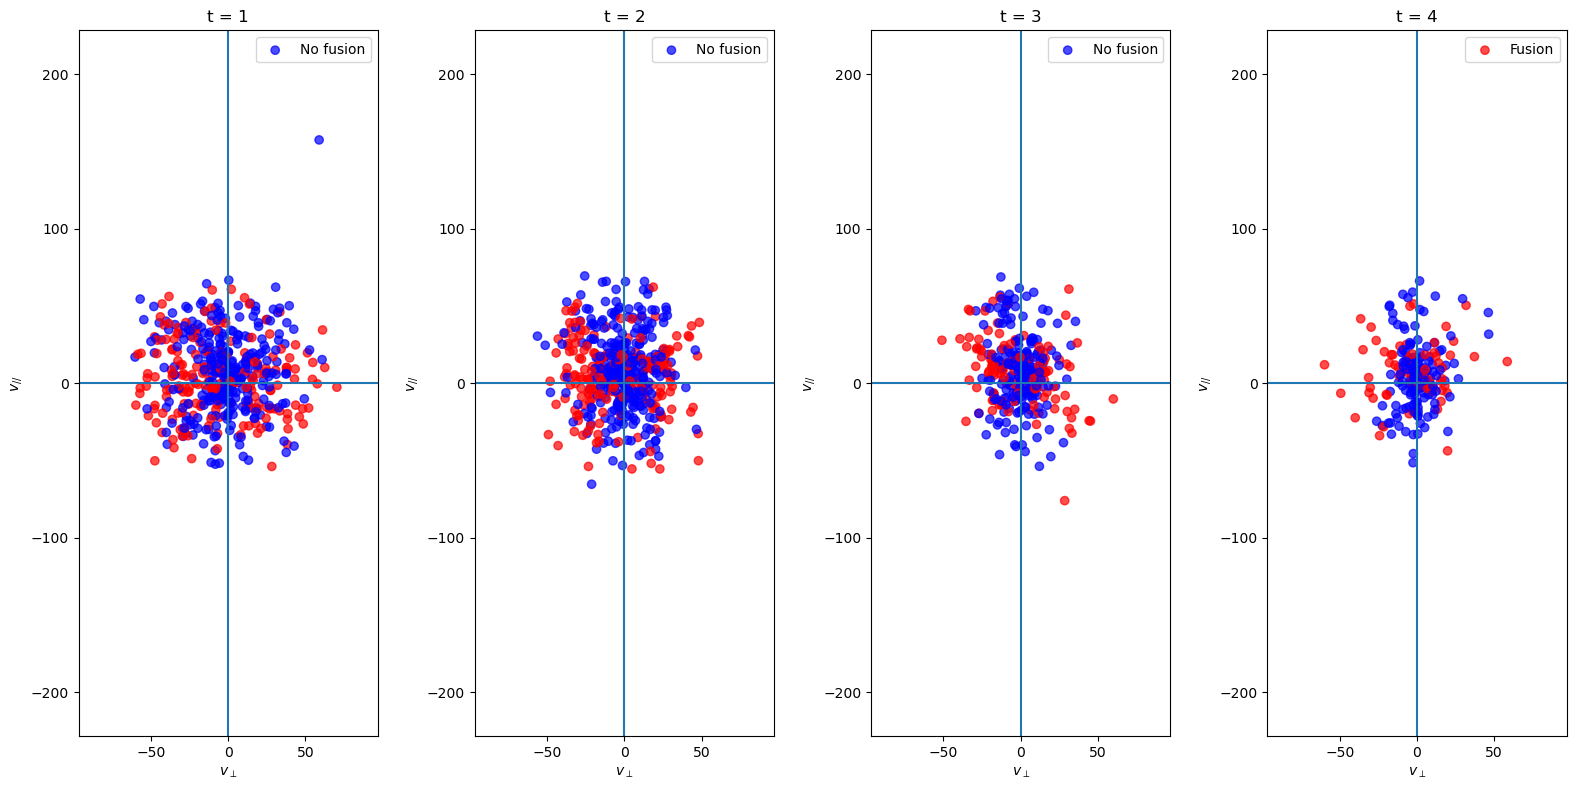

In [51]:


fig, axs = plt.subplots(1, 4, figsize=(16, 8))  # Creating a 2x4 grid of subplots

for t, ax in zip(range(1, 5), axs.ravel()):
    v_par = []
    v_perp = []
    colors = []  # Lista per memorizzare i colori dei punti
    labels = []  # Lista per memorizzare i nomi delle etichette per la legenda
    
    for b in cut_dictionary.keys(): 
        times = list(cut_dictionary[b].keys())
        
        if len(times) >= t: 
            first_time = times[t - 1]  # Adjusting the index for Python's zero-based indexing
            
            if cut_dictionary[b][first_time]: 
                try: 
                    v_par.append(cut_dictionary[b][first_time]['v_\\']) 
                    v_perp.append(cut_dictionary[b][first_time]['v_perp'])
                    
                    # Verifica se la chiave 'fusione' è presente e il valore è 'si'
                    if cut_dictionary[b][first_time].get('fusione') == 'si':
                        colors.append('red')  # Se sì, aggiunge il colore rosso
                        labels.append('Fusion')  # Aggiunge l'etichetta per la legenda
                    else:
                        colors.append('blue')  # Altrimenti, usa il colore blu
                        labels.append('No fusion')  # Aggiunge l'etichetta per la legenda
                except KeyError: 
                    continue 

    ax.scatter(v_perp, v_par, color=colors, alpha = 0.7)  # Imposta il colore dei punti
    ax.set_title(f't = {t}')  # Setting the title for each subplot
    ax.set_xlabel('$v_{\perp}$')  # Setting the x-axis label
    ax.set_ylabel('$v_{//}$')  # Setting the y-axis label
    ax.axis('equal')  # Setting the aspect ratio to ensure equal intervals on both axes
    ax.legend(labels)  # Aggiunge la legenda
    ax.axhline()
    ax.axvline()
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)

plt.savefig('puoi_eliminarmi')
plt.tight_layout()  # Adjusting the layout to prevent overlapping titles
plt.show()


# FIGURES branhces/obstacles

# TAKING ONLY BRANCHES THAT HAVE THE SAME OBSTACLE FOR 3+ FRAMES 

In [52]:
cut_dictionary_t3 = {} 
for b , values in cut_dictionary.items():
    tempi = list(values.keys()) 
    if len(tempi) >= 3: 
        
 
        for t in tempi: 
            i = tempi.index(t)
            #print(i , len(tempi) , tempi)
            if i == 0:
                #print('qui')
                if t + 1  == tempi[i+1] and   t + 2  == tempi[i+2]:
                    if values[t]['obstacle'] == values[tempi[i+1]]['obstacle'] == values[tempi[i+2]]['obstacle']:
                        vel = values[t]
                        
                        if b not in cut_dictionary_t3.keys():
                            cut_dictionary_t3[b] = {} 
                            cut_dictionary_t3[b][t] = vel
                        else: 
                            cut_dictionary_t3[b][t] = vel
            
            if i + 1  == len(tempi):         #per gli ultimi elementi 
                #print('ci sono')
                if  t - 1  == tempi[i - 1] and t - 2 == tempi[ i -2]:
                    if  values[t]['obstacle'] == values[tempi[i-1]]['obstacle'] and values[t]['obstacle'] == values[tempi[i-2]]['obstacle'] :
                        vel = values[t]
                        
                        if b not in cut_dictionary_t3.keys():
                            cut_dictionary_t3[b] = {} 
                            cut_dictionary_t3[b][t] = vel
                        else: 
                            cut_dictionary_t3[b][t] = vel
           
            else: 
                if t + 1  == tempi[i+1] and values[t]['obstacle'] == values[tempi[i+1]]['obstacle'] and  t - 1 == tempi[i - 1] and values[t]['obstacle'] == values[tempi[i-1]]['obstacle']:
                   if b not in cut_dictionary_t3.keys():
                        cut_dictionary_t3[b] = {} 
                        cut_dictionary_t3[b][t] = vel
                   else: 
                        vel = values[t]
                        cut_dictionary_t3[b][t] = vel
                try: 
                    if  t + 1  == tempi[i+1] and values[t]['obstacle'] == values[tempi[i+1]]['obstacle'] and  t + 2  == tempi[i+2] and values[t]['obstacle'] == values[tempi[i+2]]['obstacle']:
                        if b not in cut_dictionary_t3.keys():
                            vel = values[t]
                            cut_dictionary_t3[b] = {} 
                            cut_dictionary_t3[b][t] = vel
                        else: 
                            vel = values[t]
                            cut_dictionary_t3[b][t] = vel
                    if  t - 1  == tempi[i-1] and values[t]['obstacle'] == values[tempi[i-1]]['obstacle'] and  t - 2  == tempi[i-2] and values[t]['obstacle'] == values[tempi[i-2]]['obstacle']:
                        if b not in cut_dictionary_t3.keys():
                            vel = values[t]
                            cut_dictionary_t3[b] = {} 
                            cut_dictionary_t3[b][t] = vel
                        else: 
                            vel = values[t]
                            cut_dictionary_t3[b][t] = vel  
                except IndexError: 
                    pass 


cut_dictionary_t3

{792: {7: {'v_\\': 46.77055790195635,
   'v_perp': -15.389797972880242,
   'obstacle': Branche 794 - 292 noeuds},
  8: {'v_\\': 1.3416407864998712,
   'v_perp': -0.44721359549995704,
   'obstacle': Branche 794 - 292 noeuds},
  9: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds}},
 1: {21: {'fusione': 'si',
   'v_\\': 2.116238114677106,
   'v_perp': 14.428896236434813,
   'obstacle': Branche 788 - 773 noeuds},
  22: {'fusione': 'si',
   'v_\\': 0.5504167329230244,
   'v_perp': 2.167265885884408,
   'obstacle': Branche 788 - 773 noeuds},
  23: {'fusione': 'si',
   'v_\\': 3.969302227282041,
   'v_perp': 6.897117766628405,
   'obstacle': Branche 788 - 773 noeuds},
  24: {'fusione': 'si',
   'v_\\': 12.281430292656026,
   'v_perp': 10.16774806326293,
   'obstacle': Branche 788 - 773 noeuds}},
 787: {25: {'v_\\': 49.16476873963737,
   'v_perp': -22.485260443138362,
   'obstacle': Branche 693 - 222 noeuds},
  26: {'v_\\': 45.31119736829174

# FIGURES 

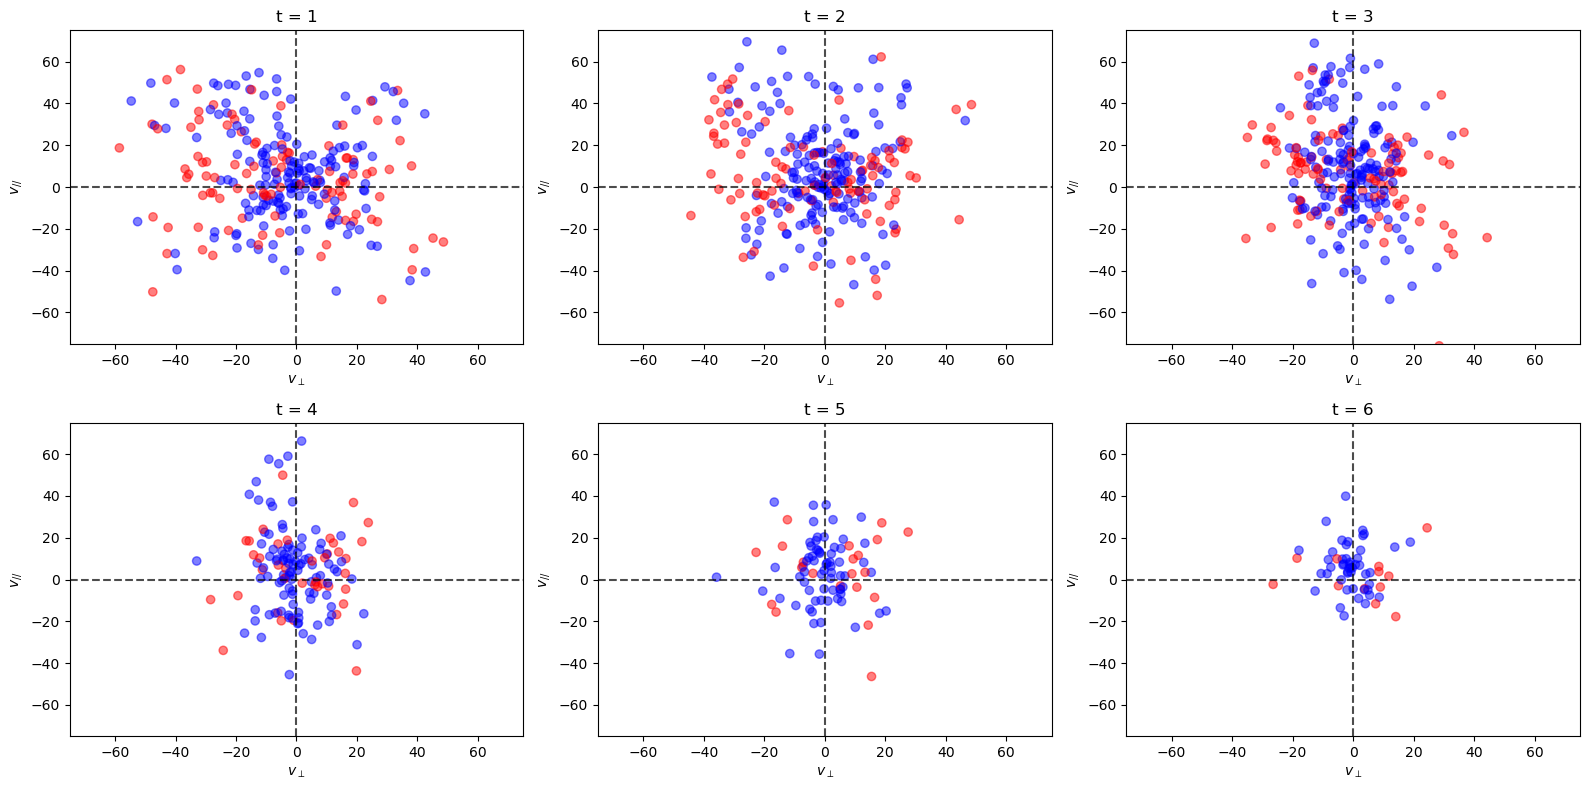

In [53]:

fig, axs = plt.subplots(2, 3, figsize=(16, 8)) 
for t, ax in zip(range(1, 7), axs.ravel()):
    v_par = []
    v_perp = []
    colors = []  
    labels = []  
    
    for b in cut_dictionary_t3.keys(): 
        times = list(cut_dictionary_t3[b].keys()) 
        g = reseau.branches[b]
        if len(times) >= t: 
            first_time = times[t - 1] 
            
            v_par.append(cut_dictionary_t3[b][first_time]['v_\\']) 
            v_perp.append(cut_dictionary_t3[b][first_time]['v_perp'])
            if cut_dictionary_t3[b][first_time].get('fusione') == 'si':
                colors.append('red') 
                labels.append('Fusione')  
            else:
                colors.append('blue')  
                labels.append('No fusione')  
    ax.scatter(v_perp, v_par ,color=colors , alpha = 0.5) 
    ax.set_title(f't = {t}')  
    ax.set_xlabel('$v_{\perp}$')  
    ax.set_ylabel('$v_{//}$')  
    ax.set_xlim(-75,75)
    ax.set_ylim(-75,75)
    ax.axhline(0, color='black', linestyle='--', alpha=0.7)  # Aggiungi linea tratteggiata sull'asse y
    ax.axvline(0, color='black', linestyle='--', alpha=0.7)  # Aggiungi linea tratteggiata sull'asse x

plt.savefig('puoi eliminarmi ')
plt.tight_layout()  
plt.show()


Since for some branches the first 3 frames elements belong to a different obstacle than the following 3, we have to re-arrange the dictionary as follows: 

# WE HAVE TO FIX IN ORDER THAT IF THE OBSTACLE CHANGES THE TIME GOES BACK TO ONE 
### $\downarrow$ FUNZIONA


In [73]:
times_dict = {}
times_dict[1] = {}
times_dict[2] = {}
times_dict[3] = {}
times_dict[4] = {}
times_dict[5] = {}
times_dict[6] = {}
times_dict[7] = {}
times_dict[8] = {}
times_dict[9] = {}
times_dict[10] = {}
times_dict[11] = {}
times_dict[12] = {}
times_dict[13] = {}
times_dict[14] = {}
branches_avoidment = dictionaire_vitesses.keys()

for b in cut_dictionary_t3.keys(): 
    
    times = list(cut_dictionary_t3[b].keys()) 
    i = 0  
    for t in times:
        if times.index(t) == 0: 
            obstacle = cut_dictionary_t3[b][t]['obstacle']
        i += 1 
        first_time = t
        old_obstacle = obstacle 
        obstacle = cut_dictionary_t3[b][t]['obstacle']
        if old_obstacle != obstacle: 
            i = 1
        if b in times_dict[i].keys():
            times_dict[i][float(str(b) + '.2') ] =  [cut_dictionary_t3[b][first_time]['v_perp'],cut_dictionary_t3[b][first_time]['v_\\']]
        try: 
            times_dict[i][b]  = [cut_dictionary_t3[b][first_time]['v_perp'],cut_dictionary_t3[b][first_time]['v_\\']]
            
        except KeyError:
            times_dict[i][b]  = [cut_dictionary_t3[b][first_time]['v_perp'],cut_dictionary_t3[b][first_time]['v_\\']]
            pass 


291
291
291
139
78
44


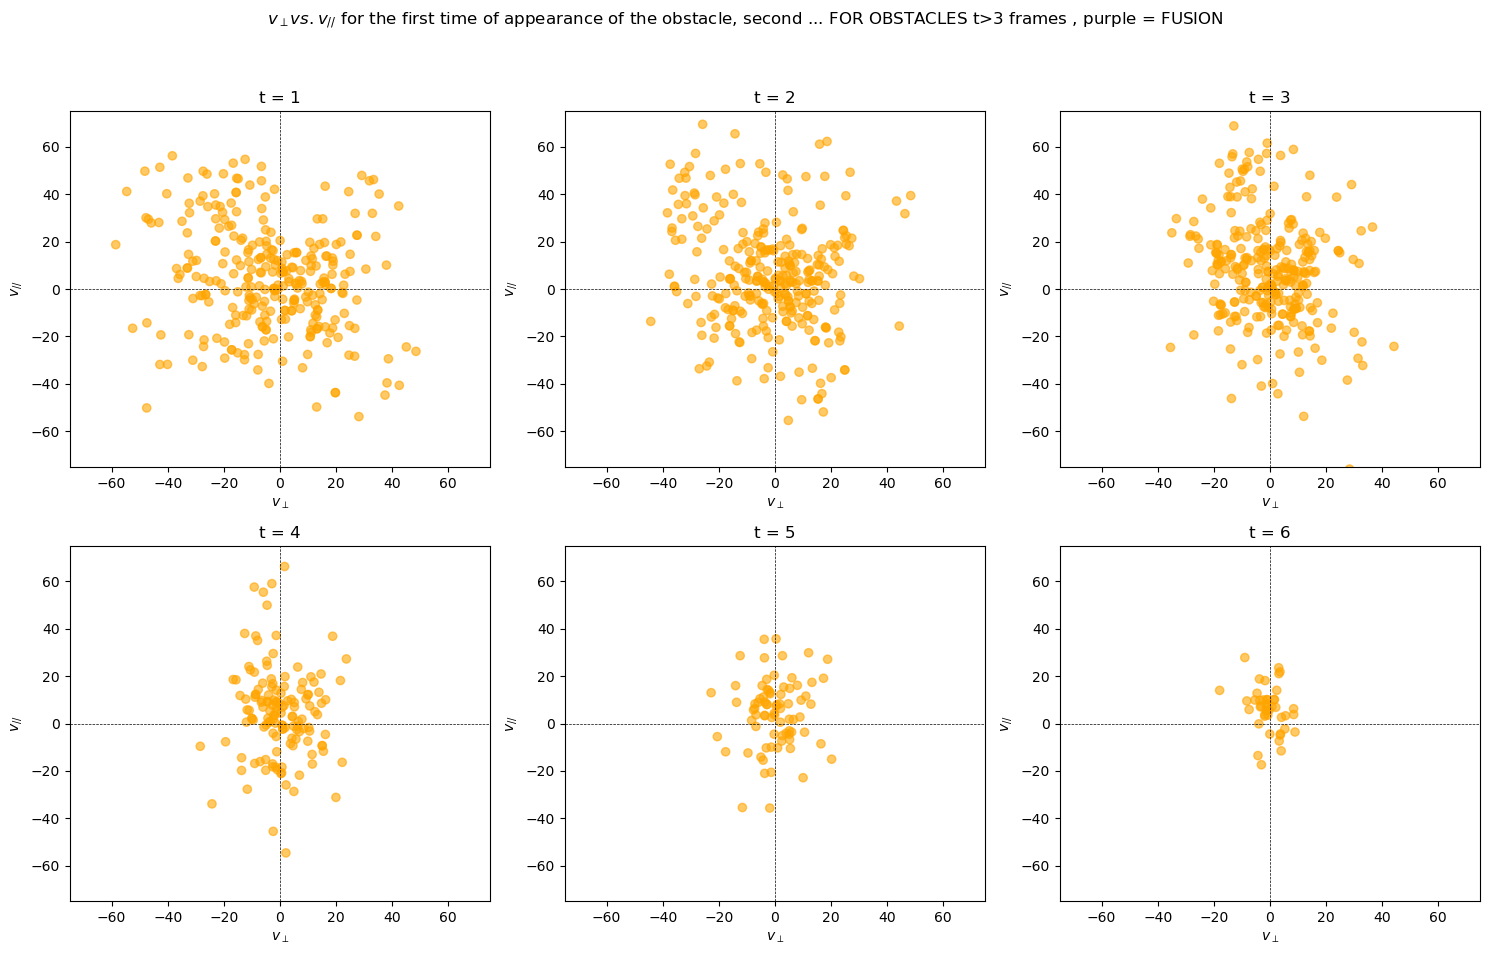

In [74]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Set the overall title for the figure
fig.suptitle('$v_{\perp} vs. v_{//}$ for the first time of appearance of the obstacle, second ... FOR OBSTACLES t>3 frames , purple = FUSION')

# Loop over the first 6 keys in times_dict (range 1 to 6)
for i, t in enumerate(range(1, 7)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    x_values = []
    y_values = []
    colors = []
    ax.set_title(f't = {t}')
    ax.set_xlabel('$v_{\perp}$')
    ax.set_ylabel('$v_{//}$')
    for v in times_dict[t]:
        x_values.append(times_dict[t][v][0])
        y_values.append(times_dict[t][v][1])
        if len( times_dict[t][v]) == 3:
            colors.append('purple')
        if len( times_dict[t][v]) == 2:
            colors.append('orange')
    print(len(x_values))
    ax.scatter(x_values, y_values, color = colors , label=f't = {t}', alpha=0.6)    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


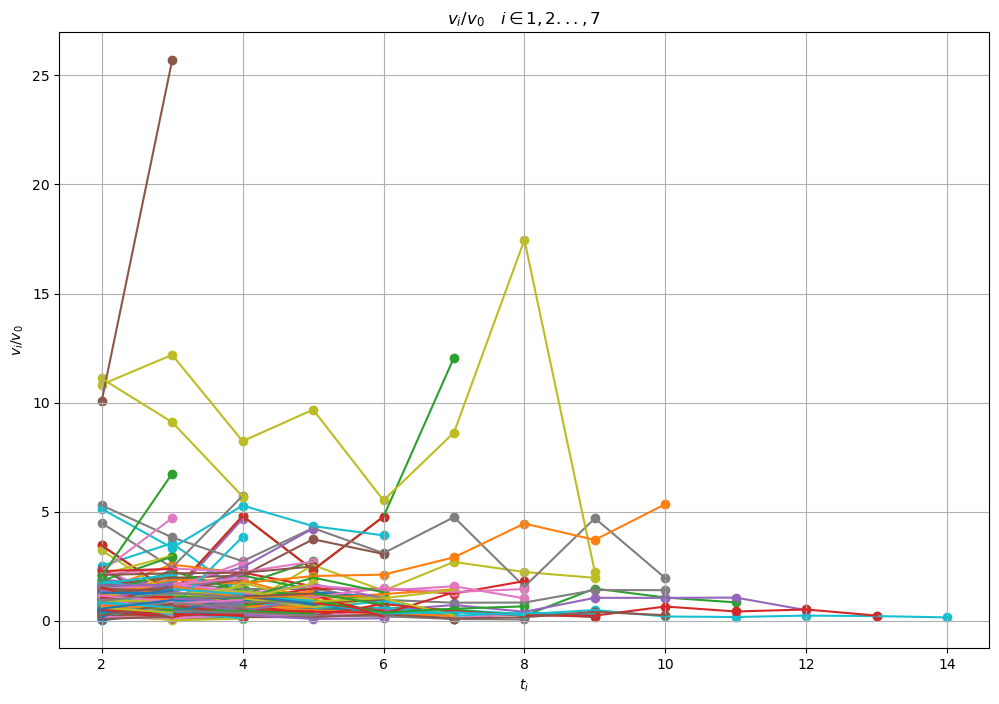

In [75]:
data = times_dict
t1_data = times_dict[1]

# Calculate modulus of velocity at t=1 for each branch
modulus_t1 = {branch: np.sqrt(v[0]**2 + v[1]**2) for branch, v in t1_data.items()}

# Initialize a dictionary to store ratios for each branch
ratios = {}

# Calculate ratio of modulus of velocity at t=1 to other times for each branch
for time, branch_data in data.items():
    if time != 1:  # Skip t=1
        for branch, v in branch_data.items():
            if branch in modulus_t1:  # Check if branch exists at t=1
                modulus = np.sqrt(v[0]**2 + v[1]**2)
                ratio =  modulus /modulus_t1[branch]
                if branch not in ratios:
                    ratios[branch] = []
                ratios[branch].append(ratio)

# Plotting
plt.figure(figsize=(12, 8))

for branch, ratio_data in ratios.items():
    plt.scatter(range(2, len(ratio_data) + 2), ratio_data, label=f"Branch {branch}")
    plt.plot(range(2, len(ratio_data) + 2), ratio_data, label=f"Branch {branch}")

plt.title('$v_i / v_0$' + '$\quad i \in 1,2...,7$')
plt.xlabel('$t_i$')
plt.ylabel('$v_i /v_0$')
plt.grid(True)
plt.show()

# THE OTHER WAY AROUND 

So far the order has been: 
1. Follow the evolution of the branch, studying his vision cone 
2. Whenever the vision cone was occupied, calulate the angolation and the orth. and normal speed 
3. Could not yet distinguish avoidment, so we distinguished between fusion and not fusion; 
We would  have expected a different beha


## NOW WE DO: 
* Look for brutal changes in speed direction
* take the branches among these that have an obstacle
* plot 

In [76]:
dictionaire_vitesses = {}


for b in reseau.branches: 
    t_start = b.get_tstart() 
    t_end = b.get_tend() 
    for i , t in enumerate(range( t_start , t_end + 1)):
        v = b.positions_vitesses()[1][i]   #vitesse du branch à le temp t 
        try:
            v_next = b.positions_vitesses()[1][i+1]
            v_next2 = b.positions_vitesses()[1][i+2]
        except IndexError: 
            continue 
        vx , vy  = v[0] , v[1]
        future_vx , future_vy = v_next[0] , v_next[1]
        norm_v = np.linalg.norm(v)
        norm_future = np.linalg.norm(v_next)
        norm_future2 = np.linalg.norm(v_next2)
        if norm_v != 0.0 and norm_future != 0.0 and norm_future2 != 0.0:
            dot_product2 = np.dot(v, v_next2)
            dot_product = np.dot(v, v_next)
            angle_radians = np.abs(np.arccos(dot_product / (norm_v * norm_future)))
            angle_radians_future =np.abs(np.arccos(dot_product2 / (norm_v * norm_future2)))
            if angle_radians > np.pi/4  or angle_radians_future > np.pi/4: #let's add to the dictionary when the angle between velocities is > pi/2 
                    if b not in dictionaire_vitesses.keys():
                        dictionaire_vitesses[b] = {} 
                        dictionaire_vitesses[b][t] = [vx , vy]
                    else: 
                        dictionaire_vitesses[b][t] = [vx , vy]
dictionaire_vitesses

C:\Users\liedcommun2\AppData\Local\Temp\ipykernel_6656\1512137408.py:22: RuntimeWarning: invalid value encountered in arccos
  angle_radians = np.abs(np.arccos(dot_product / (norm_v * norm_future)))
C:\Users\liedcommun2\AppData\Local\Temp\ipykernel_6656\1512137408.py:23: RuntimeWarning: invalid value encountered in arccos
  angle_radians_future =np.abs(np.arccos(dot_product2 / (norm_v * norm_future2)))


{Branche 0 - 694 noeuds: {11: [-38.320862897866526, 15.328345159146611],
  30: [-3.04625989093559, 62.44832776417959],
  31: [1.5917114776797128, 58.36275418158947]},
 Branche 2 - 231 noeuds: {12: [31.259144918788333, -10.083595135093011]},
 Branche 25 - 50 noeuds: {51: [38.93326510697117, 41.84033292931396]},
 Branche 33 - 55 noeuds: {53: [-1.027152174191894, -39.54535870638792]},
 Branche 36 - 81 noeuds: {46: [-13.960553718022714, 29.5880107509054],
  49: [-47.29596480173258, 8.645498942252193],
  50: [-14.84336914155289, 1.7610776947605125]},
 Branche 46 - 49 noeuds: {48: [35.02768930636672, -9.787148482661289]},
 Branche 47 - 204 noeuds: {42: [-26.79623382318994, 1.5312133613251395]},
 Branche 58 - 74 noeuds: {52: [-37.623136385568124, -41.18208171933808]},
 Branche 64 - 34 noeuds: {50: [2.75, 2.25]},
 Branche 74 - 66 noeuds: {51: [-36.042488410179544, -26.397315455342767]},
 Branche 75 - 115 noeuds: {50: [39.54476972781504, -28.129724369008187],
  51: [31.29697409037564, -51.19449

### Abbiamo preso il tempo  di tutti quelli che cambiano bruscamente la loro velocità  ( v_perp e v_parall) 

# Idea : (chiedi conferma) 

Ovviamente avere un solo valore della velocità non è sufficiente, dovremmo aggiungerne altri per seguire l'evoluzione del branch in prossimità dell'ostacolo. Ma quanti frames prendere?



#### we want to compare the new dictionaire_vitesses with dizionario_branches, dictionary storing for each time the closest obstacle for the branch. 
So it'll be like: if the obstacle at that time has an abrupt change in velocity direction and his vision cone is occupied from another branch, we take its $v_{\perp}$ and $v_{//}$

In [77]:
common_element = {}
chiavi_velocità = dictionaire_vitesses.keys()
for branch , time_obstacle_dict in dizionario_branches.items():  # take branch by branch its closest obstacles for every time 
    b = reseau.branches[branch]     
    if b  in chiavi_velocità:            # se il branch è tra quelli che evitano un ostacolo 
        for t in time_obstacle_dict.keys():      #itero su tutti i tempi in cui il branch ha u ostacolo 
            if t in dictionaire_vitesses[b]: 
                if b not in common_element.keys():
                    common_element[b] = {} 
                    common_element[b][t] =  time_obstacle_dict[t]
                else: 
                    common_element[b][t] =  time_obstacle_dict[t]
common_element                

{Branche 792 - 528 noeuds: {8: {'v_\\': 1.3416407864998712,
   'v_perp': -0.44721359549995704,
   'obstacle': Branche 794 - 292 noeuds},
  9: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds},
  40: {'v_\\': 23.529271390996286,
   'v_perp': -51.85105077787229,
   'obstacle': Branche 1350 - 11 noeuds}},
 Branche 787 - 256 noeuds: {10: {'v_\\': 17.894994939789203,
   'v_perp': -0.5149638831594014,
   'obstacle': Branche 788 - 773 noeuds}},
 Branche 788 - 773 noeuds: {8: {'v_\\': 5.241550497988625,
   'v_perp': -8.688060372523504,
   'obstacle': Branche 768 - 154 noeuds}},
 Branche 1069 - 145 noeuds: {20: {'v_\\': 20.92988371295543,
   'v_perp': 14.716063488518543,
   'obstacle': Branche 792 - 528 noeuds}},
 Branche 766 - 29 noeuds: {33: {'fusione': 'si',
   'v_\\': 16.252950884229968,
   'v_perp': -2.3983824023247964,
   'obstacle': Branche 792 - 528 noeuds}},
 Branche 1095 - 140 noeuds: {25: {'v_\\': 21.58450756545408,
   'v_perp': -0.

# STUCK HERE: I am able to identify the instant of interest but how do I decide how to follow its evolution? 
### let's visualize the branches I selected

# FROM THE FIGURES I guess: let's try to take the time before and the time after indicated but problems  :
 * I cannot guarantee there will be an obstacle and if there is no obstacle I can't know a priori 

In [78]:

expanded_dict ={}
for b , t_dict in common_element.items(): 
    for t in t_dict.keys():    # times of common_element dictionary in which there is a common element 
                    k = t - 1 
                    l = t + 1
                    f = reseau.branches.index(b)
                    if any(key in dizionario_branches[f] for key in [k, l]):
        
                        if b not in expanded_dict.keys():
                            expanded_dict[b] = {} 
                            expanded_dict[b][t] = dizionario_branches[f][t]
                            if k in dizionario_branches[f]: 
                                expanded_dict[b][k] = dizionario_branches[f][t]
                            else: 
                                
                                expanded_dict[b][k] = velocity(b , k)
                            if l in dizionario_branches[f]: 
                                expanded_dict[b][l] = dizionario_branches[f][l]
                            else: 
                                
                                expanded_dict[b][l] = velocity(b , l)
                        else: 
                            expanded_dict[b][t] = dizionario_branches[f][t]
                            if k in dizionario_branches[f]: 
                                expanded_dict[b][k] = dizionario_branches[f][t]
                            else: 
                                
                                expanded_dict[b][k] = velocity(b , k)
                            if l in dizionario_branches[f]: 
                                expanded_dict[b][l] = dizionario_branches[f][l]
                            else: 
                                
                                expanded_dict[b][l] = velocity(b , l)
                            
                      
expanded_dict

{Branche 792 - 528 noeuds: {8: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds},
  7: {'v_\\': 1.3416407864998712,
   'v_perp': -0.44721359549995704,
   'obstacle': Branche 794 - 292 noeuds},
  9: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds},
  10: array([[ -8.53014606, -32.25461478]]),
  40: {'v_\\': 23.529271390996286,
   'v_perp': -51.85105077787229,
   'obstacle': Branche 1350 - 11 noeuds},
  39: array([[36.9378868 , 50.09384648]]),
  41: {'fusione': 'si',
   'v_\\': 51.41075683366809,
   'v_perp': -2.2483610763114967,
   'obstacle': Branche 1320 - 351 noeuds}},
 Branche 787 - 256 noeuds: {10: {'v_\\': 17.894994939789203,
   'v_perp': -0.5149638831594014,
   'obstacle': Branche 788 - 773 noeuds},
  9: {'v_\\': 17.894994939789203,
   'v_perp': -0.5149638831594014,
   'obstacle': Branche 788 - 773 noeuds},
  11: array([[-15.60693404,  -7.55174228]])},
 Branche 1069 - 145 noeu

#### If the times are consegutive they will have the same obstacle $\rightarrow$ per ora ho appeso questa cosa e ho rimosso quelli che non hanno l'ostacolo, ossia 85 elementi per semplicità


In [79]:
def are_consecutive(num1, num2):

    difference = abs(num1 - num2)
    return difference == 1
from collections import OrderedDict

def sort_inner_dict_keys(outer_dict):

    sorted_dict = {}

    for outer_key, inner_dict in outer_dict.items():
        sorted_keys = sorted(inner_dict.keys())
        
        sorted_inner_dict = {key: inner_dict[key] for key in sorted_keys}
        
        sorted_dict[outer_key] = sorted_inner_dict
    
    return sorted_dict
expanded_dict = sort_inner_dict_keys(expanded_dict)
expanded_dict

{Branche 792 - 528 noeuds: {7: {'v_\\': 1.3416407864998712,
   'v_perp': -0.44721359549995704,
   'obstacle': Branche 794 - 292 noeuds},
  8: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds},
  9: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds},
  10: array([[ -8.53014606, -32.25461478]]),
  39: array([[36.9378868 , 50.09384648]]),
  40: {'v_\\': 23.529271390996286,
   'v_perp': -51.85105077787229,
   'obstacle': Branche 1350 - 11 noeuds},
  41: {'fusione': 'si',
   'v_\\': 51.41075683366809,
   'v_perp': -2.2483610763114967,
   'obstacle': Branche 1320 - 351 noeuds}},
 Branche 787 - 256 noeuds: {9: {'v_\\': 17.894994939789203,
   'v_perp': -0.5149638831594014,
   'obstacle': Branche 788 - 773 noeuds},
  10: {'v_\\': 17.894994939789203,
   'v_perp': -0.5149638831594014,
   'obstacle': Branche 788 - 773 noeuds},
  11: array([[-15.60693404,  -7.55174228]])},
 Branche 1069 - 145 noeu

# plot 

In [80]:
times_dict = {}
times_dict[1] = {}
times_dict[2] = {}
times_dict[3] = {}
times_dict[4] = {}
times_dict[5] = {}
times_dict[6] = {}
times_dict[7] = {}
times_dict[8] = {}
times_dict[9] = {}
times_dict[10] = {}
times_dict[11] = {}
times_dict[12] = {}
times_dict[13] = {}
times_dict[14] = {}

for b in  expanded_dict.keys(): 
    
    times = list(expanded_dict[b].keys()) 
    i = 0 
    
    for t in times:
         
        if times.index(t) == 0: 
            obstacle = expanded_dict[b][t]['obstacle']
        i += 1 
        first_time = t
        old_obstacle = obstacle 
        obstacle = expanded_dict[b][t]['obstacle']
        if old_obstacle != obstacle: 
            i = 1
        if b in times_dict[i].keys():
            f = reseau.branches.index(b)
            times_dict[i][float(str(f) + '.2') ] =  [expanded_dict[b][first_time]['v_perp'],expanded_dict[b][first_time]['v_\\']]
      
        times_dict[i][b]  = [expanded_dict[b][first_time]['v_perp'],expanded_dict[b][first_time]['v_\\'] ]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

1
1
1
0
0
0


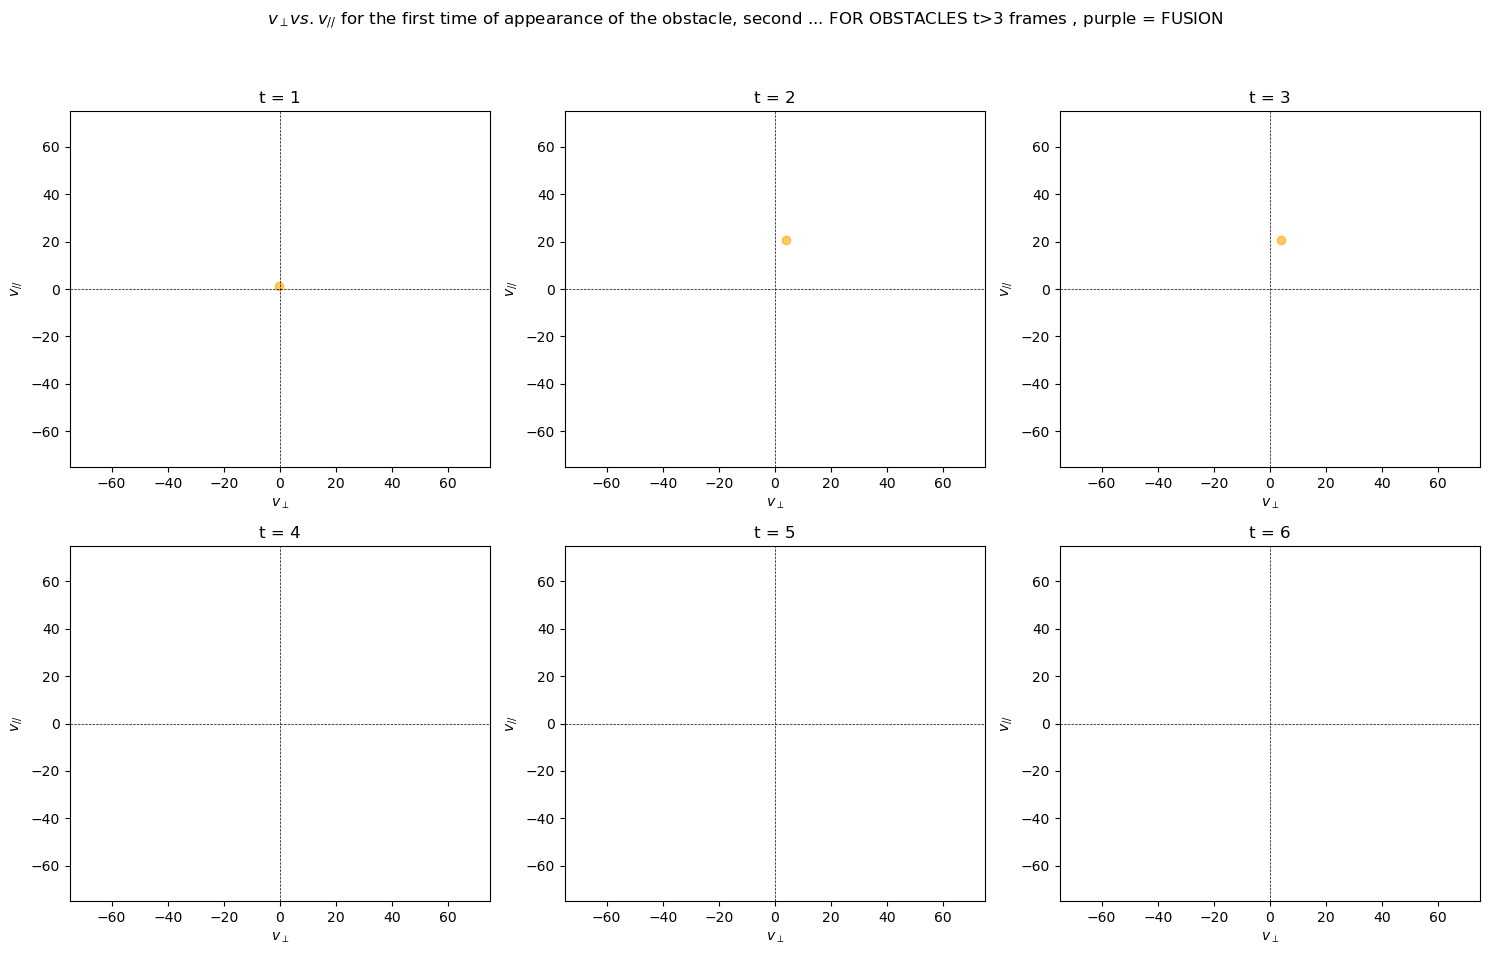

In [81]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Set the overall title for the figure
fig.suptitle('$v_{\perp} vs. v_{//}$ for the first time of appearance of the obstacle, second ... FOR OBSTACLES t>3 frames , purple = FUSION')

# Loop over the first 6 keys in times_dict (range 1 to 6)
for i, t in enumerate(range(1, 7)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    x_values = []
    y_values = []
    colors = []
    ax.set_title(f't = {t}')
    ax.set_xlabel('$v_{\perp}$')
    ax.set_ylabel('$v_{//}$')
    for v in times_dict[t]:
        x_values.append(times_dict[t][v][0])
        y_values.append(times_dict[t][v][1])
        if len( times_dict[t][v]) == 3:
            colors.append('purple')
        if len( times_dict[t][v]) == 2:
            colors.append('orange')
    print(len(x_values))
    ax.scatter(x_values, y_values, color = colors , label=f't = {t}', alpha=0.6)    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
data = times_dict
t1_data = times_dict[1]

modulus_t1 = {branch: np.sqrt(v[0]**2 + v[1]**2) for branch, v in t1_data.items()}

ratios = {}

for time, branch_data in data.items():
    if time != 1:  # Skip t=1
        for branch, v in branch_data.items():
            colors=[]

            if branch in modulus_t1:  # Check if branch exists at t=1
                modulus = np.sqrt(v[0]**2 + v[1]**2)
                ratio =  modulus /modulus_t1[branch]
                if branch not in ratios:
                    ratios[branch] = []
                    ratios[branch].append(1)
                ratios[branch].append(ratio)


plt.figure(figsize=(12, 8))

for branch, ratio_data in ratios.items():
    color = []
    if len(times_dict[1][branch]) == 2:
        color.append( 'orange')
    if len(times_dict[1][branch]) == 3:
        color.append('purple')
    plt.scatter(range(1, len(ratio_data) + 1), ratio_data, color = color, label=f"Branch {branch}")
    plt.plot(range(1, len(ratio_data) + 1), ratio_data, alpha = 0.5,  label=f"Branch {branch}")
    plt.plot(range(1, len(ratio_data) + 1) , np.ones(len(ratio_data) ) , linestyle = '--')
plt.title('$v_i / v_0$' + '$\quad i \in 1,2...,7$')
plt.xlabel('$t_i$')
plt.ylabel('$v_i /v_0$')
plt.ylim(0,3)
plt.grid(True)
plt.show()

In [ ]:
dictionaire_vitesses

In [ ]:
chiavi_vitesses = [list(dictionaire_vitesses[i].keys()) for i in dictionaire_vitesses.keys()]

In [ ]:
chiavi_vitesses = [item for sublist in chiavi_vitesses for item in sublist]


In [82]:
selected_items = {}

# Itera attraverso ogni chiave esterna di cut_dictionary_t3
for key, inner_dict in cut_dictionary_t3.items():
    # Crea una lista di gruppi di tempi consecutivi
    time_groups = []
    temp_group = []
    sorted_times = sorted(inner_dict.keys())
    
    for i in range(len(sorted_times) - 1):
        # Se il tempo successivo è consecutivo, aggiungi al gruppo temporaneo
        if sorted_times[i] + 1 == sorted_times[i+1]:
            temp_group.append(sorted_times[i])
        else:
            # Aggiungi l'ultimo tempo al gruppo temporaneo
            temp_group.append(sorted_times[i])
            
            # Se il gruppo temporaneo ha almeno 3 tempi, aggiungi al time_groups
            if len(temp_group) >= 3:
                time_groups.append(temp_group)
            
            # Reset del gruppo temporaneo
            temp_group = []
    
    # Aggiungi l'ultimo gruppo temporaneo, se necessario
    if temp_group:
        temp_group.append(sorted_times[-1])
        if len(temp_group) >= 3:
            time_groups.append(temp_group)
            
            
    branch = reseau.branches[key]
    if branch in list(dictionaire_vitesses.keys()):
        time = list(dictionaire_vitesses[branch].keys())
        for group in time_groups:        
            for t in group:
                if t in time:
                    selected_items[key] = inner_dict
                    break  

selected_items


{792: {7: {'v_\\': 46.77055790195635,
   'v_perp': -15.389797972880242,
   'obstacle': Branche 794 - 292 noeuds},
  8: {'v_\\': 1.3416407864998712,
   'v_perp': -0.44721359549995704,
   'obstacle': Branche 794 - 292 noeuds},
  9: {'v_\\': 20.526346370610597,
   'v_perp': 3.814630741440906,
   'obstacle': Branche 794 - 292 noeuds}},
 1069: {17: {'v_\\': 4.416766307292977,
   'v_perp': 3.2305490704771485,
   'obstacle': Branche 792 - 528 noeuds},
  18: {'v_\\': 6.869243196706386,
   'v_perp': 6.573376916698433,
   'obstacle': Branche 792 - 528 noeuds},
  19: {'v_\\': 5.398911373572852,
   'v_perp': 2.8582471977738626,
   'obstacle': Branche 792 - 528 noeuds},
  20: {'v_\\': 20.92988371295543,
   'v_perp': 14.716063488518543,
   'obstacle': Branche 792 - 528 noeuds}},
 766: {33: {'fusione': 'si',
   'v_\\': 16.252950884229968,
   'v_perp': -2.3983824023247964,
   'obstacle': Branche 792 - 528 noeuds},
  34: {'fusione': 'si',
   'v_\\': 5.684237861559195,
   'v_perp': 2.8617197509918704,
 

In [83]:
times_dict = {}
times_dict[1] = {}
times_dict[2] = {}
times_dict[3] = {}
times_dict[4] = {}
times_dict[5] = {}
times_dict[6] = {}
times_dict[7] = {}
times_dict[8] = {}
times_dict[9] = {}
times_dict[10] = {}
times_dict[11] = {}
times_dict[12] = {}
times_dict[13] = {}
times_dict[14] = {}

for b in selected_items.keys(): 
    
    times = list(selected_items[b].keys()) 
    i = 0 
    
    for t in times:
         
        if times.index(t) == 0: 
            obstacle = selected_items[b][t]['obstacle']
        i += 1 
        first_time = t
        old_obstacle = obstacle 
        obstacle = selected_items[b][t]['obstacle']
        if old_obstacle != obstacle: 
            i = 1
        if b in times_dict[i].keys():
            times_dict[i][float(str(b) + '.2') ] =  [selected_items[b][first_time]['v_perp'],selected_items[b][first_time]['v_\\']]
        try: 
            times_dict[i][b]  = [selected_items[b][first_time]['v_perp'],selected_items[b][first_time]['v_\\'] , [selected_items[b][first_time]['fusione']]]
            
        except KeyError:
            times_dict[i][b]  = [selected_items[b][first_time]['v_perp'],selected_items[b][first_time]['v_\\']]
            pass 

83
83
83
41
25
17


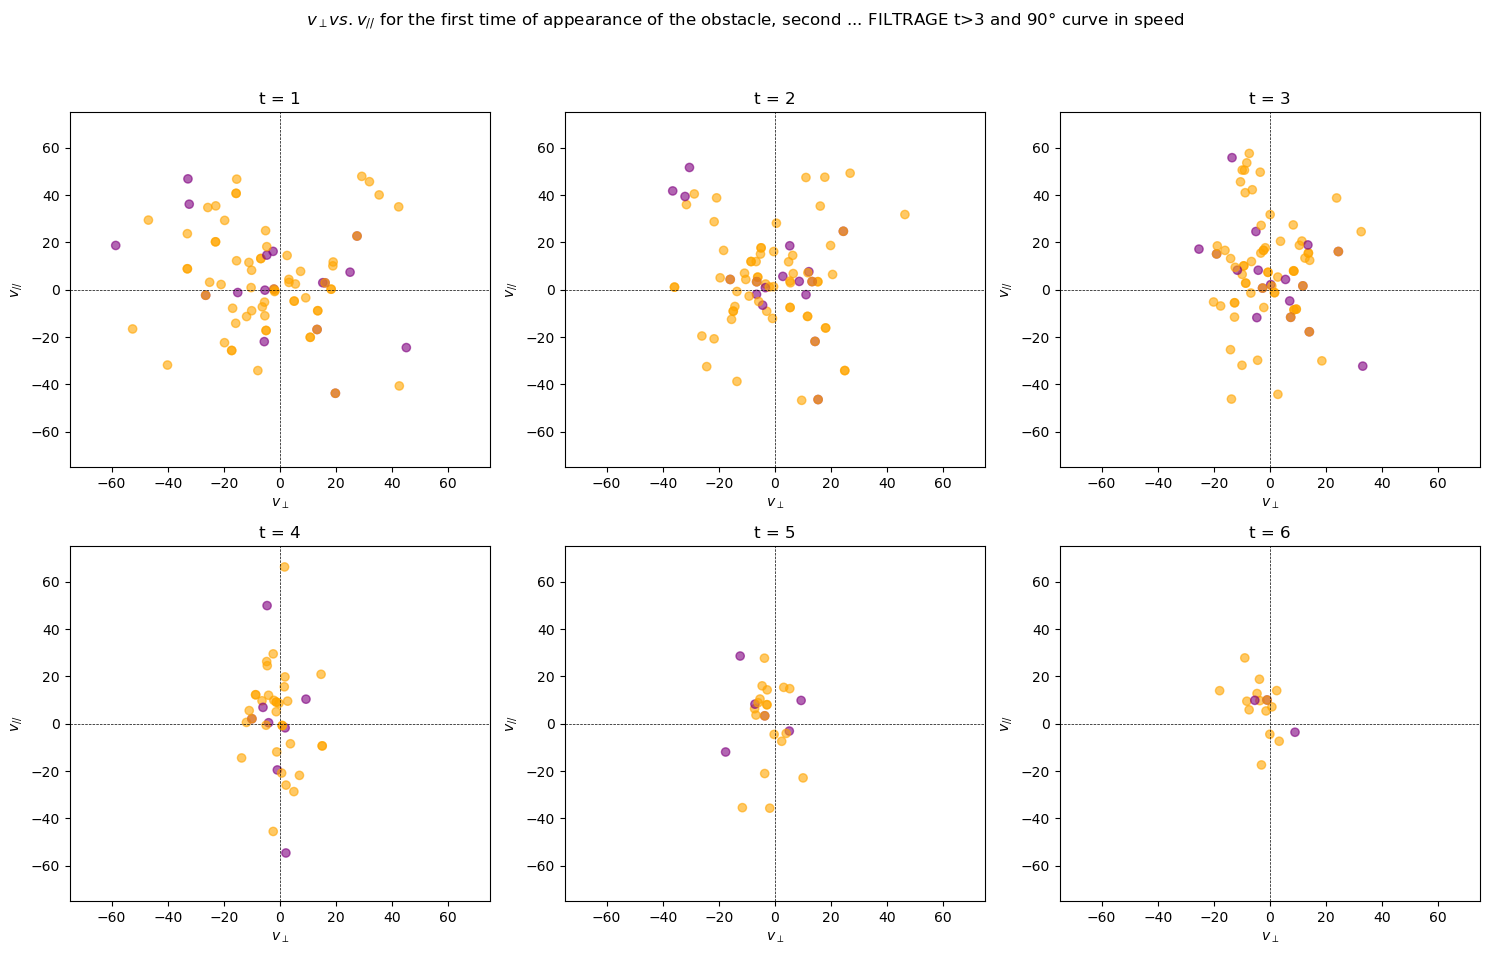

In [84]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Set the overall title for the figure
fig.suptitle('$v_{\perp} vs. v_{//}$ for the first time of appearance of the obstacle, second ... FILTRAGE t>3 and 90° curve in speed')

for i, t in enumerate(range(1, 7)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    x_values = []
    y_values = []
    colors = []
    ax.set_title(f't = {t}')
    ax.set_xlabel('$v_{\perp}$')
    ax.set_ylabel('$v_{//}$')
    for v in times_dict[t]:
        x_values.append(times_dict[t][v][0])
        y_values.append(times_dict[t][v][1])
        if len( times_dict[t][v]) == 3:
            colors.append('purple')
        if len( times_dict[t][v]) == 2:
            colors.append('orange')
    print(len(x_values))
    ax.scatter(x_values, y_values, color = colors , label=f't = {t}', alpha=0.6)    
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


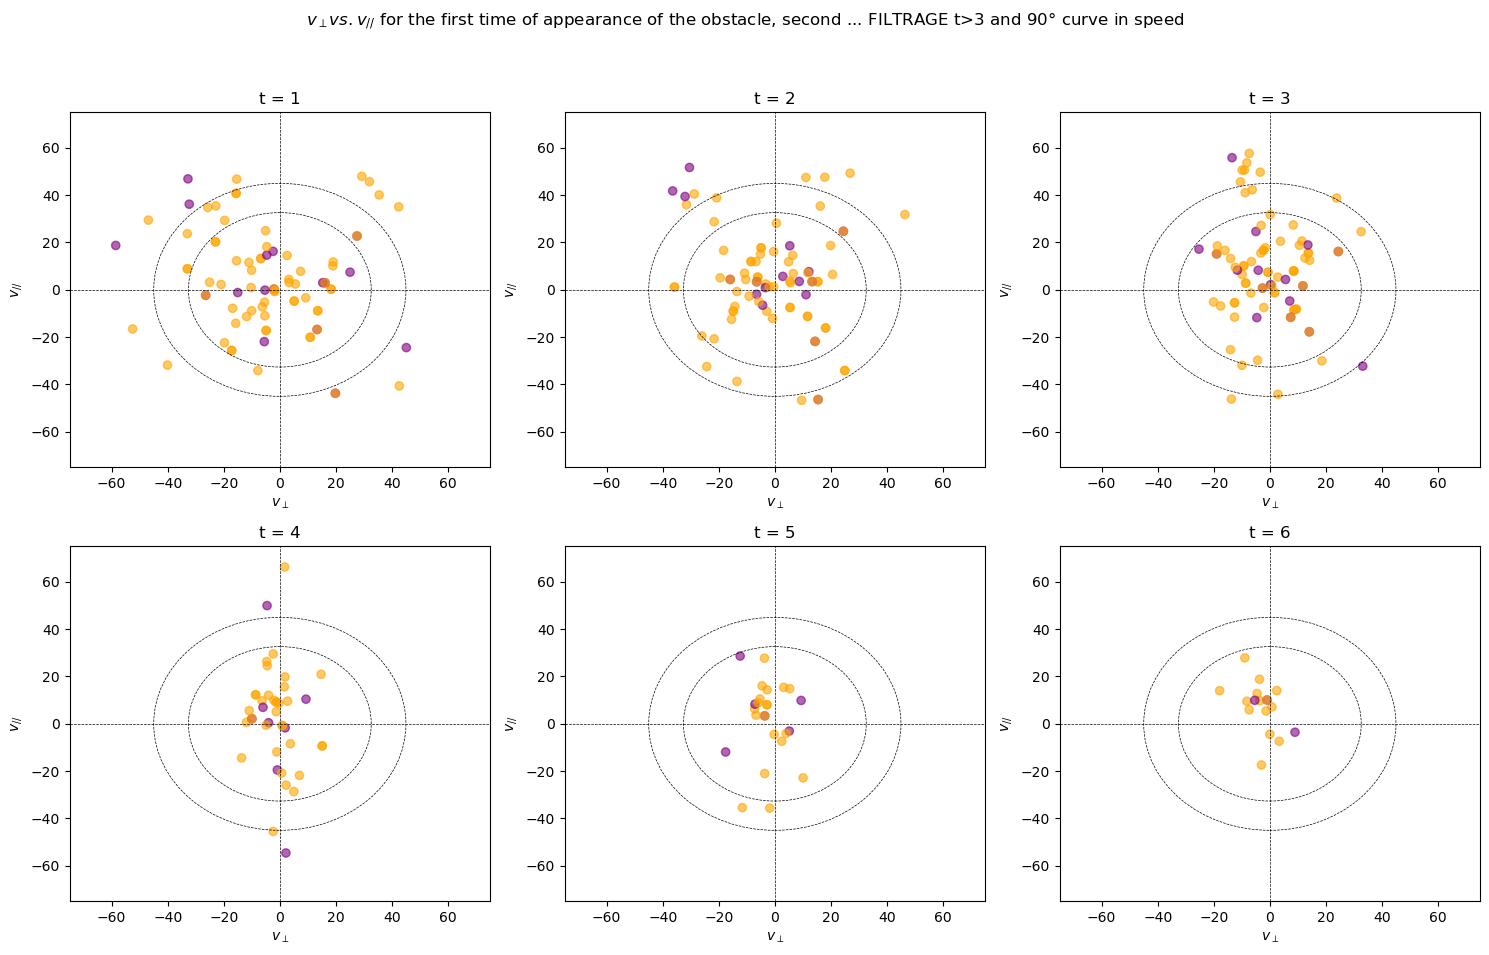

In [85]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Set the overall title for the figure
fig.suptitle('$v_{\perp} vs. v_{//}$ for the first time of appearance of the obstacle, second ... FILTRAGE t>3 and 90° curve in speed')

# Define radii R and T
R = 20  # You can adjust the value as needed
T = 40  # You can adjust the value as needed

for i, t in enumerate(range(1, 7)):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    x_values = []
    y_values = []
    colors = []
    ax.set_title(f't = {t}')
    ax.set_xlabel('$v_{\perp}$')
    ax.set_ylabel('$v_{//}$')

    # Add scatter points to the subplot
    for v in times_dict[t]:
        x_values.append(times_dict[t][v][0])
        y_values.append(times_dict[t][v][1])
        if len(times_dict[t][v]) == 3:
            colors.append('purple')
        elif len(times_dict[t][v]) == 2:
            colors.append('orange')

    ax.scatter(x_values, y_values, color=colors, label=f't = {t}', alpha=0.6)
    
    # Draw dashed lines for horizontal and vertical axes
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
    
    # Draw dashed circles for radii R and T
    circle_R = plt.Circle((0, 0), 45, color='black', linestyle='--', fill=False, linewidth=0.5)
    circle_T = plt.Circle((0, 0), 32.625, color='black', linestyle='--', fill=False, linewidth=0.5)
    ax.add_patch(circle_R)
    ax.add_patch(circle_T)

    ax.set_xlim(-75, 75)
    ax.set_ylim(-75, 75)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
